<a href="https://colab.research.google.com/github/Gilf641/EVA4/blob/master/S10_V1Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Mount your G-Drive**

In [0]:
from __future__ import print_function
%matplotlib inline

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


**Add Library Path in your def search path**

In [0]:
import sys
sys.path.append('/content/drive/My Drive/EVA4/updLib2/evaLibrary')
!ls '/content/drive/My Drive/EVA4/updLib2/evaLibrary'

AlbTestTransforms.py   all.py	       execute.py    __pycache__
AlbTrainTransforms.py  DataLoaders.py  Gradcam.py    resNet.py
albumentations.py      displayData.py  LR_Finder.py  rohan_library.py


In [0]:
# !pip install torch-lr-finder -v --global-option="amp"

**Import required libraries**

In [0]:
from rohan_library import *
import execute
from resNet import ResNet18
import displayData as display
import Gradcam as gc
import albumentations as alb
import DataLoaders as loader
import AlbTestTransforms
import AlbTrainTransforms
import LR_Finder as lrf

REQUIRED LIBRARIES LOADED...


  pip install torch-lr-finder -v --global-option="amp"


**Albumentations**

In [0]:
# from albumentations import Compose, Normalize
# from albumentations.pytorch import ToTensor
albTrain = AlbTrainTransforms.train_transforms()
albTest = AlbTestTransforms.test_transforms()

**Load the Datasets**

In [0]:
train = torchvision.datasets.CIFAR10(root = './data', train = True, download = True, transform = albTrain)
test = torchvision.datasets.CIFAR10(root = './data', train = False, download = True, transform = albTest)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


**DataLoader for Train & Test Dataset**

In [0]:
dl = loader.DataLoaders()
trainLoader = dl.dataLoader(train)
testLoader = dl.dataLoader(test)


In [0]:
dataiter = iter(trainLoader)

images, labels = dataiter.next()
print(images.shape)
print(labels.shape)

torch.Size([128, 3, 32, 32])
torch.Size([128])


**Displaying Random Images**

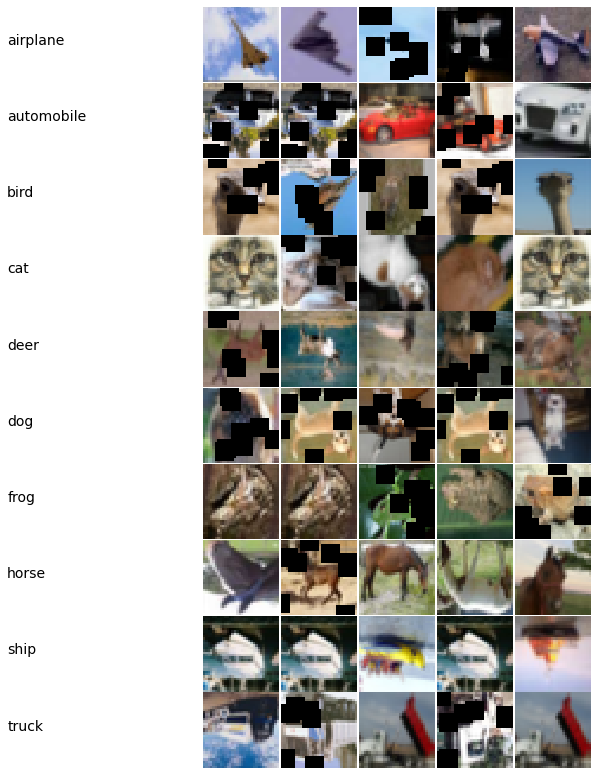

In [0]:
display.classImages(trainLoader)

**Model Summary**

In [0]:
from torchsummary import summary

use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')
print('Device set to ', device)

model = ResNet18().to(device)
summary(model, input_size=(3,32,32))

Device set to  cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-1

**LR Finder**

In [0]:
torch.manual_seed(10)
criterion = execute.cross_entropy_loss()
optimizer = optim.SGD(model.parameters(), lr = 1e-4)#, weight_decay=1e-4)
model = ResNet18().to(device)


**FastAI Approach**

In [0]:
def fastaiApproach(model, optimizer, criterion, device ='cuda'):#, end_lr, num_iter): # fastai approach
  lrF = lrf.LRFinder(model, optimizer, criterion, device)
  lrF.range_test(trainLoader, end_lr=10, num_iter =200, step_mode='exp')
  lrF.plot()
  lrF.reset()

def lsApproach(model, optimizer, criterion, device ='cuda'): # leslie smith approach
  lrF = lrf.LRFinder(model, optimizer, criterion, device)
  lrF.range_test(trainLoader, testLoader, end_lr=10, num_iter =200, step_mode='exp')
  lrF.plot()
  lrF.reset()


fastaiApproach(model, optimizer, criterion, device)


RuntimeError: ignored

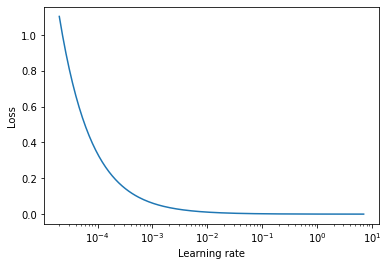

In [0]:
lsApproach(model, optimizer, criterion, device)

**Modelling**

In [0]:
incorrectSamples = []
correctSamples = []
correctLabels = []
model = ResNet18().to(device)


criterion = execute.cross_entropy_loss()
optimizer = optim.SGD(model.parameters(), lr = 1e-3, momentum=0.9, weight_decay=1e-4, nesterov = True) # change it to 0.01 or 0.009
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'min', patience=2, verbose=False)


model1 = execute.Test_Train(model, device, optimizer, criterion)
EPOCHS = 10


for epoch in range(1, EPOCHS+1):
  print('EPOCH: ',epoch)
  model1.train(trainLoader, epoch, L1lambda = 1e-5 )
  model1.test(testLoader, 'model1.pt', correctSamples, correctLabels, incorrectSamples)
  scheduler.step(model1.test_losses[-1])


  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH:  1



Loss=3.5171279907226562 Batch_id=0 Accuracy=9.38:   0%|          | 0/391 [00:00<?, ?it/s]
Loss=3.5171279907226562 Batch_id=0 Accuracy=9.38:   0%|          | 1/391 [00:00<03:08,  2.07it/s]
Loss=3.4250597953796387 Batch_id=1 Accuracy=8.20:   0%|          | 1/391 [00:00<03:08,  2.07it/s]
Loss=3.4250597953796387 Batch_id=1 Accuracy=8.20:   1%|          | 2/391 [00:00<02:39,  2.43it/s]
Loss=3.46828031539917 Batch_id=2 Accuracy=7.29:   1%|          | 3/391 [00:00<02:12,  2.92it/s]
Loss=3.4134907722473145 Batch_id=3 Accuracy=7.42:   1%|          | 3/391 [00:01<02:12,  2.92it/s]
Loss=3.4134907722473145 Batch_id=3 Accuracy=7.42:   1%|          | 4/391 [00:01<01:53,  3.42it/s]
Loss=3.412118911743164 Batch_id=4 Accuracy=7.66:   1%|          | 4/391 [00:01<01:53,  3.42it/s] 
Loss=3.412118911743164 Batch_id=4 Accuracy=7.66:   1%|▏         | 5/391 [00:01<01:36,  3.99it/s]
Loss=3.383765459060669 Batch_id=5 Accuracy=9.77:   1%|▏         | 5/391 [00:01<01:36,  3.99it/s]
Loss=3.383765459060669 Batch_id

Validation loss has  decreased (inf --> 1.1496).  Saving model ...

Test set: Average loss: 1.1496, Accuracy: 4556/10000 (45.56%)

EPOCH:  2



Loss=2.6230781078338623 Batch_id=0 Accuracy=42.97:   0%|          | 0/391 [00:00<?, ?it/s]
Loss=2.6230781078338623 Batch_id=0 Accuracy=42.97:   0%|          | 1/391 [00:00<04:00,  1.62it/s]
Loss=2.6666054725646973 Batch_id=1 Accuracy=42.97:   0%|          | 1/391 [00:00<04:00,  1.62it/s]
Loss=2.6666054725646973 Batch_id=1 Accuracy=42.97:   1%|          | 2/391 [00:00<03:07,  2.08it/s]
Loss=2.5717520713806152 Batch_id=2 Accuracy=44.53:   1%|          | 2/391 [00:00<03:07,  2.08it/s]
Loss=2.5717520713806152 Batch_id=2 Accuracy=44.53:   1%|          | 3/391 [00:00<02:31,  2.57it/s]
Loss=2.625150203704834 Batch_id=3 Accuracy=44.14:   1%|          | 3/391 [00:01<02:31,  2.57it/s] 
Loss=2.625150203704834 Batch_id=3 Accuracy=44.14:   1%|          | 4/391 [00:01<02:03,  3.12it/s]
Loss=2.643162488937378 Batch_id=4 Accuracy=43.59:   1%|          | 4/391 [00:01<02:03,  3.12it/s]
Loss=2.643162488937378 Batch_id=4 Accuracy=43.59:   1%|▏         | 5/391 [00:01<01:44,  3.68it/s]
Loss=2.6265463829040

Validation loss has  decreased (1.1496 --> 1.0155).  Saving model ...

Test set: Average loss: 1.0155, Accuracy: 5239/10000 (52.39%)

EPOCH:  3



Loss=2.3699440956115723 Batch_id=0 Accuracy=50.00:   0%|          | 0/391 [00:00<?, ?it/s]
Loss=2.3699440956115723 Batch_id=0 Accuracy=50.00:   0%|          | 1/391 [00:00<03:55,  1.66it/s]
Loss=2.3975558280944824 Batch_id=1 Accuracy=48.83:   0%|          | 1/391 [00:00<03:55,  1.66it/s]
Loss=2.3975558280944824 Batch_id=1 Accuracy=48.83:   1%|          | 2/391 [00:00<03:04,  2.10it/s]
Loss=2.279341459274292 Batch_id=2 Accuracy=51.30:   1%|          | 2/391 [00:00<03:04,  2.10it/s] 
Loss=2.279341459274292 Batch_id=2 Accuracy=51.30:   1%|          | 3/391 [00:00<02:27,  2.63it/s]
Loss=2.5311543941497803 Batch_id=3 Accuracy=50.59:   1%|          | 3/391 [00:01<02:27,  2.63it/s]
Loss=2.5311543941497803 Batch_id=3 Accuracy=50.59:   1%|          | 4/391 [00:01<02:01,  3.19it/s]
Loss=2.3951902389526367 Batch_id=4 Accuracy=51.72:   1%|          | 4/391 [00:01<02:01,  3.19it/s]
Loss=2.3951902389526367 Batch_id=4 Accuracy=51.72:   1%|▏         | 5/391 [00:01<01:42,  3.76it/s]
Loss=2.50641870498


Test set: Average loss: 1.2900, Accuracy: 5701/10000 (57.01%)

EPOCH:  4



Loss=2.2261056900024414 Batch_id=0 Accuracy=53.91:   0%|          | 0/391 [00:00<?, ?it/s]
Loss=2.2261056900024414 Batch_id=0 Accuracy=53.91:   0%|          | 1/391 [00:00<03:58,  1.64it/s]
Loss=2.4088709354400635 Batch_id=1 Accuracy=50.00:   0%|          | 1/391 [00:00<03:58,  1.64it/s]
Loss=2.4088709354400635 Batch_id=1 Accuracy=50.00:   1%|          | 2/391 [00:00<03:07,  2.08it/s]
Loss=2.245699405670166 Batch_id=2 Accuracy=52.60:   1%|          | 2/391 [00:00<03:07,  2.08it/s] 
Loss=2.245699405670166 Batch_id=2 Accuracy=52.60:   1%|          | 3/391 [00:00<02:30,  2.58it/s]
Loss=2.3525853157043457 Batch_id=3 Accuracy=51.95:   1%|          | 3/391 [00:01<02:30,  2.58it/s]
Loss=2.3525853157043457 Batch_id=3 Accuracy=51.95:   1%|          | 4/391 [00:01<02:03,  3.13it/s]
Loss=2.2050890922546387 Batch_id=4 Accuracy=54.06:   1%|          | 4/391 [00:01<02:03,  3.13it/s]
Loss=2.2050890922546387 Batch_id=4 Accuracy=54.06:   1%|▏         | 5/391 [00:01<01:45,  3.67it/s]
Loss=2.42858457565


Test set: Average loss: 1.7217, Accuracy: 5783/10000 (57.83%)

EPOCH:  5



Loss=2.147916793823242 Batch_id=0 Accuracy=60.16:   0%|          | 0/391 [00:00<?, ?it/s]
Loss=2.147916793823242 Batch_id=0 Accuracy=60.16:   0%|          | 1/391 [00:00<04:12,  1.54it/s]
Loss=2.2035183906555176 Batch_id=1 Accuracy=61.33:   0%|          | 1/391 [00:00<04:12,  1.54it/s]
Loss=2.2035183906555176 Batch_id=1 Accuracy=61.33:   1%|          | 2/391 [00:00<03:14,  2.00it/s]
Loss=2.05916166305542 Batch_id=2 Accuracy=62.24:   1%|          | 2/391 [00:00<03:14,  2.00it/s]  
Loss=2.05916166305542 Batch_id=2 Accuracy=62.24:   1%|          | 3/391 [00:00<02:35,  2.50it/s]
Loss=2.330867290496826 Batch_id=3 Accuracy=58.59:   1%|          | 3/391 [00:01<02:35,  2.50it/s]
Loss=2.330867290496826 Batch_id=3 Accuracy=58.59:   1%|          | 4/391 [00:01<02:06,  3.06it/s]
Loss=2.291931629180908 Batch_id=4 Accuracy=58.59:   1%|          | 4/391 [00:01<02:06,  3.06it/s]
Loss=2.291931629180908 Batch_id=4 Accuracy=58.59:   1%|▏         | 5/391 [00:01<01:47,  3.60it/s]
Loss=2.185770273208618 Ba

Validation loss has  decreased (1.0155 --> 0.8321).  Saving model ...

Test set: Average loss: 0.8321, Accuracy: 6471/10000 (64.71%)

EPOCH:  6



Loss=2.1191859245300293 Batch_id=0 Accuracy=62.50:   0%|          | 0/391 [00:00<?, ?it/s]
Loss=2.1191859245300293 Batch_id=0 Accuracy=62.50:   0%|          | 1/391 [00:00<04:06,  1.59it/s]
Loss=2.1313297748565674 Batch_id=1 Accuracy=62.11:   0%|          | 1/391 [00:00<04:06,  1.59it/s]
Loss=2.1313297748565674 Batch_id=1 Accuracy=62.11:   1%|          | 2/391 [00:00<03:12,  2.02it/s]
Loss=2.2004785537719727 Batch_id=2 Accuracy=62.50:   1%|          | 2/391 [00:00<03:12,  2.02it/s]
Loss=2.2004785537719727 Batch_id=2 Accuracy=62.50:   1%|          | 3/391 [00:00<02:33,  2.53it/s]
Loss=2.266740322113037 Batch_id=3 Accuracy=62.11:   1%|          | 3/391 [00:01<02:33,  2.53it/s] 
Loss=2.266740322113037 Batch_id=3 Accuracy=62.11:   1%|          | 4/391 [00:01<02:06,  3.05it/s]
Loss=2.1549456119537354 Batch_id=4 Accuracy=61.09:   1%|          | 4/391 [00:01<02:06,  3.05it/s]
Loss=2.1549456119537354 Batch_id=4 Accuracy=61.09:   1%|▏         | 5/391 [00:01<01:47,  3.60it/s]
Loss=2.20479965209


Test set: Average loss: 1.2154, Accuracy: 6490/10000 (64.90%)

EPOCH:  7



Loss=2.0236659049987793 Batch_id=0 Accuracy=64.84:   0%|          | 0/391 [00:00<?, ?it/s]
Loss=2.0236659049987793 Batch_id=0 Accuracy=64.84:   0%|          | 1/391 [00:00<03:15,  2.00it/s]
Loss=2.045665740966797 Batch_id=1 Accuracy=66.80:   0%|          | 1/391 [00:00<03:15,  2.00it/s] 
Loss=2.045665740966797 Batch_id=1 Accuracy=66.80:   1%|          | 2/391 [00:00<02:37,  2.47it/s]
Loss=2.1609206199645996 Batch_id=2 Accuracy=63.28:   1%|          | 2/391 [00:00<02:37,  2.47it/s]
Loss=2.1609206199645996 Batch_id=2 Accuracy=63.28:   1%|          | 3/391 [00:00<02:11,  2.95it/s]
Loss=2.044227123260498 Batch_id=3 Accuracy=63.48:   1%|          | 3/391 [00:01<02:11,  2.95it/s] 
Loss=2.044227123260498 Batch_id=3 Accuracy=63.48:   1%|          | 4/391 [00:01<01:54,  3.37it/s]
Loss=2.038379669189453 Batch_id=4 Accuracy=63.44:   1%|          | 4/391 [00:01<01:54,  3.37it/s]
Loss=2.038379669189453 Batch_id=4 Accuracy=63.44:   1%|▏         | 5/391 [00:01<01:39,  3.89it/s]
Loss=1.90881156921386

Validation loss has  decreased (0.8321 --> 0.5292).  Saving model ...

Test set: Average loss: 0.5292, Accuracy: 6878/10000 (68.78%)

EPOCH:  8



Loss=2.084324598312378 Batch_id=0 Accuracy=62.50:   0%|          | 0/391 [00:00<?, ?it/s]
Loss=2.084324598312378 Batch_id=0 Accuracy=62.50:   0%|          | 1/391 [00:00<03:55,  1.66it/s]
Loss=2.0623245239257812 Batch_id=1 Accuracy=65.62:   0%|          | 1/391 [00:00<03:55,  1.66it/s]
Loss=2.0623245239257812 Batch_id=1 Accuracy=65.62:   1%|          | 2/391 [00:00<03:07,  2.07it/s]
Loss=2.0043206214904785 Batch_id=2 Accuracy=66.15:   1%|          | 2/391 [00:00<03:07,  2.07it/s]
Loss=2.0043206214904785 Batch_id=2 Accuracy=66.15:   1%|          | 3/391 [00:00<02:32,  2.54it/s]
Loss=2.0374131202697754 Batch_id=3 Accuracy=66.02:   1%|          | 3/391 [00:01<02:32,  2.54it/s]
Loss=2.0374131202697754 Batch_id=3 Accuracy=66.02:   1%|          | 4/391 [00:01<02:05,  3.09it/s]
Loss=2.002516746520996 Batch_id=4 Accuracy=67.19:   1%|          | 4/391 [00:01<02:05,  3.09it/s] 
Loss=2.002516746520996 Batch_id=4 Accuracy=67.19:   1%|▏         | 5/391 [00:01<01:45,  3.66it/s]
Loss=1.8790597915649


Test set: Average loss: 0.6037, Accuracy: 6970/10000 (69.70%)

EPOCH:  9



Loss=1.898683786392212 Batch_id=0 Accuracy=68.75:   0%|          | 0/391 [00:00<?, ?it/s]
Loss=1.898683786392212 Batch_id=0 Accuracy=68.75:   0%|          | 1/391 [00:00<03:53,  1.67it/s]
Loss=2.0462043285369873 Batch_id=1 Accuracy=67.97:   0%|          | 1/391 [00:00<03:53,  1.67it/s]
Loss=2.0462043285369873 Batch_id=1 Accuracy=67.97:   1%|          | 2/391 [00:00<03:04,  2.11it/s]
Loss=1.91060209274292 Batch_id=2 Accuracy=68.75:   1%|          | 2/391 [00:00<03:04,  2.11it/s]  
Loss=1.91060209274292 Batch_id=2 Accuracy=68.75:   1%|          | 3/391 [00:00<02:27,  2.62it/s]
Loss=1.836164951324463 Batch_id=3 Accuracy=69.92:   1%|          | 3/391 [00:01<02:27,  2.62it/s]
Loss=1.836164951324463 Batch_id=3 Accuracy=69.92:   1%|          | 4/391 [00:01<02:02,  3.15it/s]
Loss=2.028393507003784 Batch_id=4 Accuracy=69.22:   1%|          | 4/391 [00:01<02:02,  3.15it/s]
Loss=2.028393507003784 Batch_id=4 Accuracy=69.22:   1%|▏         | 5/391 [00:01<01:44,  3.68it/s]
Loss=2.1305885314941406 B


Test set: Average loss: 0.9675, Accuracy: 6998/10000 (69.98%)

EPOCH:  10



Loss=2.0115933418273926 Batch_id=0 Accuracy=68.75:   0%|          | 0/391 [00:00<?, ?it/s]
Loss=2.0115933418273926 Batch_id=0 Accuracy=68.75:   0%|          | 1/391 [00:00<03:49,  1.70it/s]
Loss=1.7854328155517578 Batch_id=1 Accuracy=72.66:   0%|          | 1/391 [00:00<03:49,  1.70it/s]
Loss=1.7854328155517578 Batch_id=1 Accuracy=72.66:   1%|          | 2/391 [00:00<03:00,  2.15it/s]
Loss=1.9909591674804688 Batch_id=2 Accuracy=70.57:   1%|          | 2/391 [00:00<03:00,  2.15it/s]
Loss=1.9909591674804688 Batch_id=2 Accuracy=70.57:   1%|          | 3/391 [00:00<02:25,  2.67it/s]
Loss=1.8327499628067017 Batch_id=3 Accuracy=71.29:   1%|          | 3/391 [00:01<02:25,  2.67it/s]
Loss=1.8327499628067017 Batch_id=3 Accuracy=71.29:   1%|          | 4/391 [00:01<01:59,  3.24it/s]
Loss=1.7542786598205566 Batch_id=4 Accuracy=72.66:   1%|          | 4/391 [00:01<01:59,  3.24it/s]
Loss=1.7542786598205566 Batch_id=4 Accuracy=72.66:   1%|▏         | 5/391 [00:01<01:41,  3.79it/s]
Loss=2.0458824634

Validation loss has  decreased (0.5292 --> 0.4291).  Saving model ...

Test set: Average loss: 0.4291, Accuracy: 7195/10000 (71.95%)



**Plot Train & Test Curves**

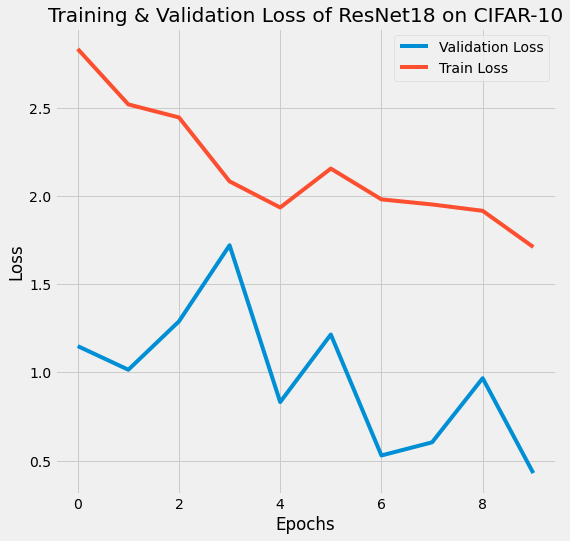

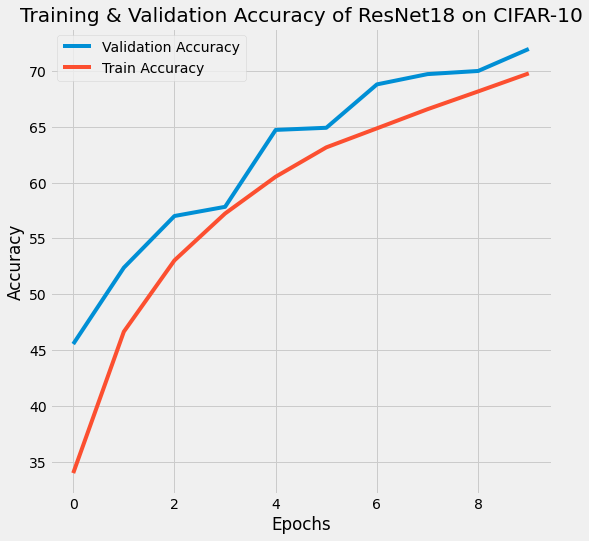

In [0]:
accuracyElements = [(model1.test_acc,"Validation Accuracy"),(model1.train_epoch_end,"Train Accuracy")]
lossElements = [(model1.test_losses,"Validation Loss"),(model1.train_losses,"Train Loss")]

for i in range(1):
  display.plot_curve(lossElements,'Training & Validation Loss of ResNet18 on CIFAR-10', y_label='Loss')
  display.plot_curve(accuracyElements,'Training & Validation Accuracy of ResNet18 on CIFAR-10')

**Data for GradCam**

**GradCam Implementation**

In [0]:

images = [x['image'] for x in incorrectSamples[10:20]]
target_classes = [l['label'] for l in incorrectSamples[10:20]]
predicted_classes = [p['prediction'] for p in incorrectSamples[10:20]]
# print(images)
print('***target-classes***')
tc = [classes[t] for t in target_classes]


print('***predicted-classes***')
pc = [classes[p] for p in predicted_classes]


***target-classes***
***predicted-classes***


torch.Size([10, 10])
Generating Grad-CAM @layer1
Generating Grad-CAM @layer2
Generating Grad-CAM @layer3
Generating Grad-CAM @layer4


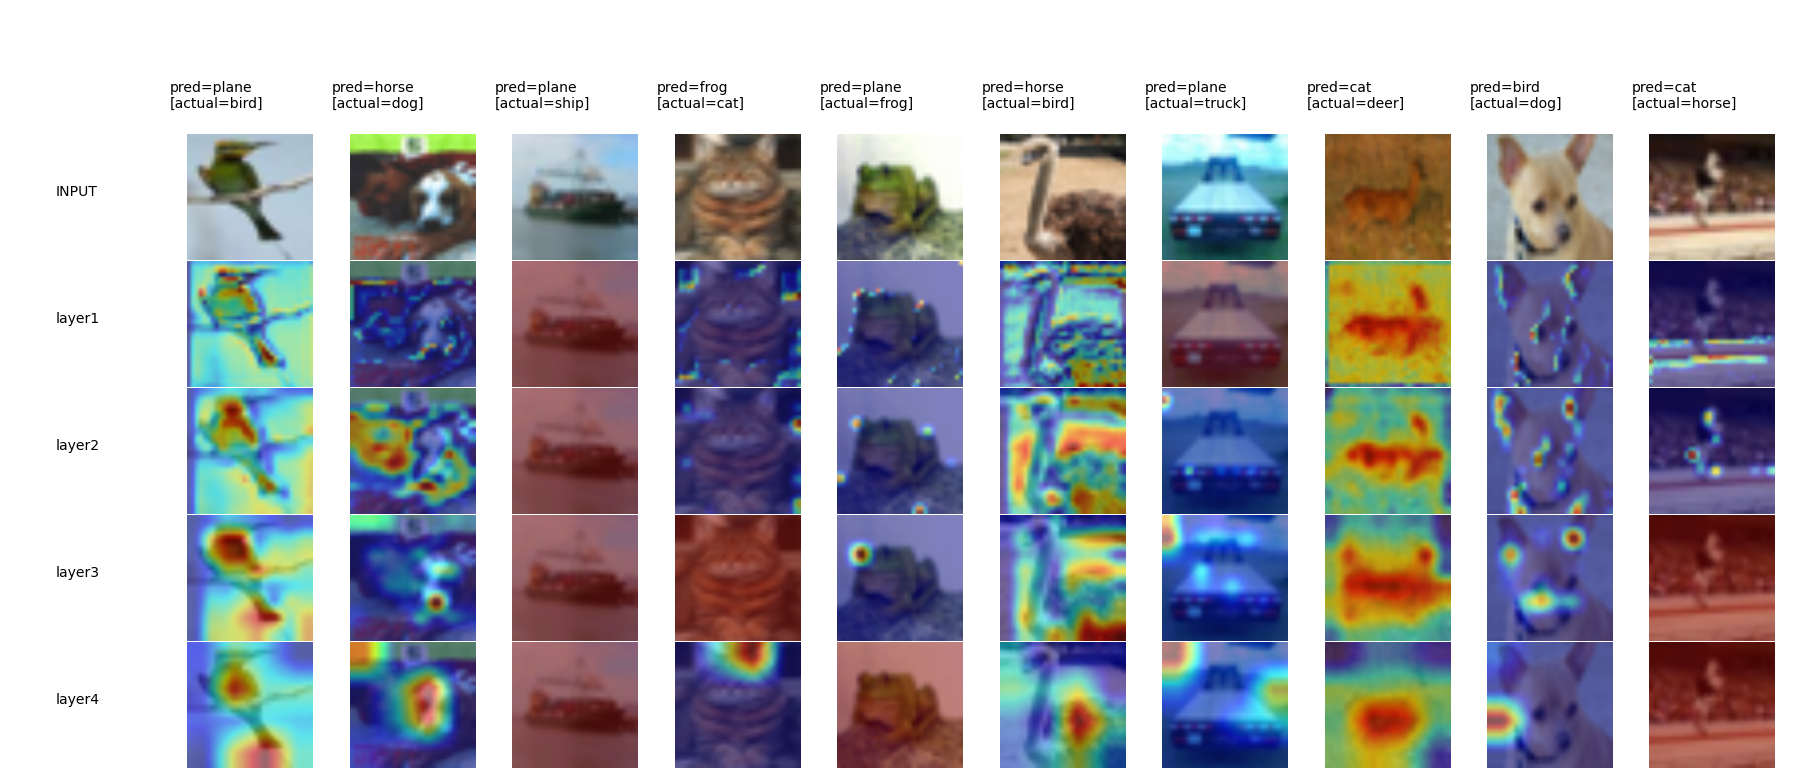

In [0]:

model = ResNet18().to(device)
image_size = (3,32,32)

target_layers = ["layer1", "layer2", "layer3", "layer4"]
gradcam_output, probs, predicted_classes = gc.GRADCAM(images, device, target_classes, model, target_layers) # target_classes required only in GRADCAM func

gc.PLOT(gradcam_output, images, target_layers, image_size, display.unnormalize, tc, pc)


MessageError: ignored

<Figure size 936x936 with 0 Axes>

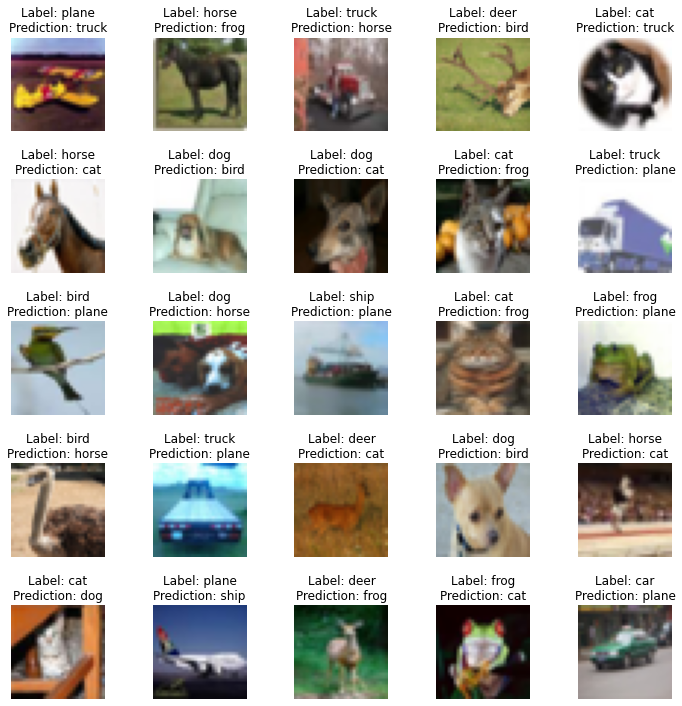

In [0]:
display.misclassifiedOnes(model, testLoader, incorrectSamples,'Misclassfied.png')